## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as RandForest
from sklearn.metrics import mean_squared_error as mse

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df_resample = df.resample("1H").sum()

df_resample.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


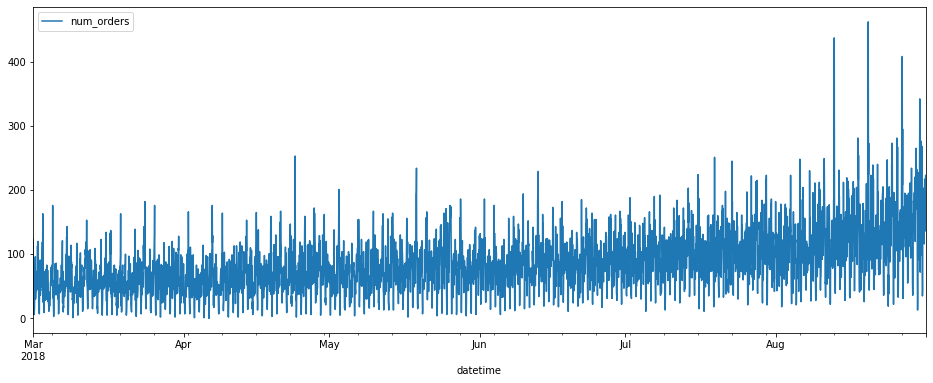

In [5]:
df_resample.plot()
plt.show()

# 2. Анализ

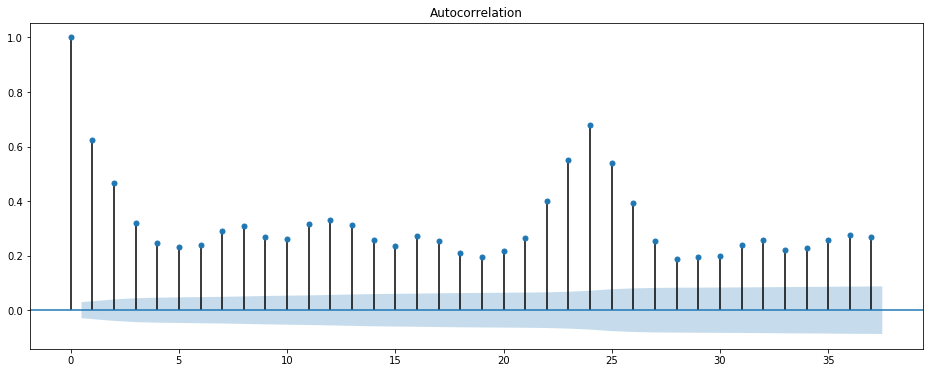

In [6]:
plot_acf(df_resample)
plt.show()

In [7]:
adfuller(df_resample["num_orders"]) #Dickey-Fuller test

(-3.068924289027946,
 0.02894005140261368,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

> Критическое значение = `-3.06` < `-2.86` прие 5-% доверительном интервале. Следовательно, ряд можно считать **стационарным.** Однако с виду на графике есть сезонность.

In [8]:
df_resample.index[:30]

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               '2018-03-01 10:00:00', '2018-03-01 11:00:00',
               '2018-03-01 12:00:00', '2018-03-01 13:00:00',
               '2018-03-01 14:00:00', '2018-03-01 15:00:00',
               '2018-03-01 16:00:00', '2018-03-01 17:00:00',
               '2018-03-01 18:00:00', '2018-03-01 19:00:00',
               '2018-03-01 20:00:00', '2018-03-01 21:00:00',
               '2018-03-01 22:00:00', '2018-03-01 23:00:00',
               '2018-03-02 00:00:00', '2018-03-02 01:00:00',
               '2018-03-02 02:00:00', '2018-03-02 03:00:00',
               '2018-03-02 04:00:00', '2018-03-02 05:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')

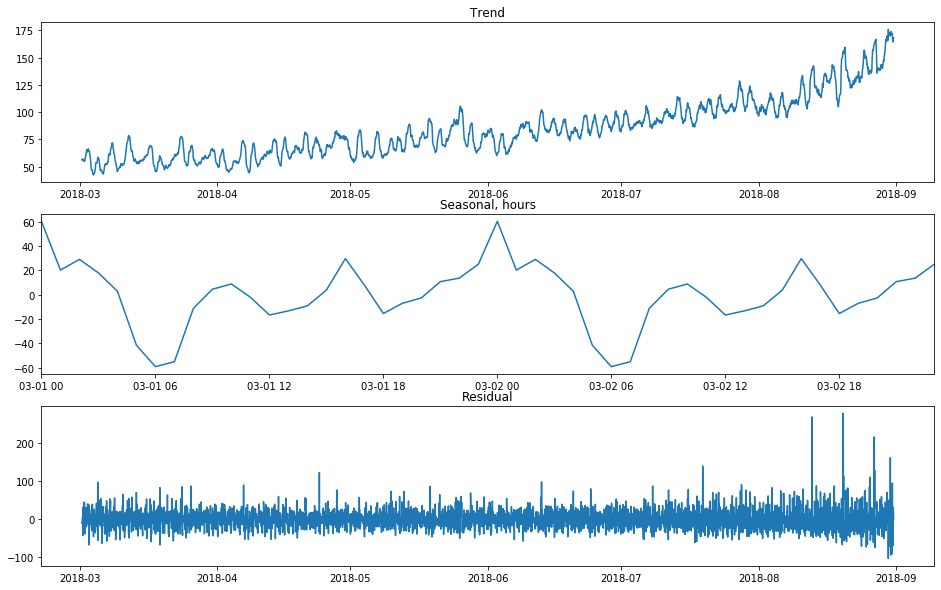

In [9]:
decomposed = seasonal_decompose(df_resample)

fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal)
axs[1].set_title("Seasonal, hours")
axs[1].set_xlim(('2018-03-01 00:00:00','2018-03-02 23:00:00'))

axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")

plt.show()

# 3. Обучение

In [10]:
def rmse(first_list, second_list):
    return np.sqrt(mse(first_list, second_list))
    
def make_features(data, max_lag, rolling_mean_size, differentiate=False):
    ARMA_df = data.copy(deep=True)
    ARMA_df['dayofweek'] = ARMA_df.index.dayofweek
    ARMA_df['hour'] = ARMA_df.index.hour

    
    for lag in range(1, max_lag + 1):
        ARMA_df['lag_{}'.format(lag)] = ARMA_df['num_orders'].shift(lag)

    ARMA_df['rolling_mean'] = ARMA_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    if differentiate:
        ARMA_df["diff"] = ARMA_df['num_orders'] - ARMA_df["num_orders"].shift(1)
        ARMA_df["diff"] = ARMA_df['num_orders'] - ARMA_df["num_orders"].shift(24) # in-day seasonal part
    
    return ARMA_df

In [11]:
train, test = train_test_split(df_resample, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

X_train = train.drop("num_orders", axis=1)
y_train = train["num_orders"]

X_test = test.drop("num_orders", axis=1)
y_test = test["num_orders"]

Predict with median(rmse): 87.15277582981295
Predict with mean(rmse): 84.74414402014742


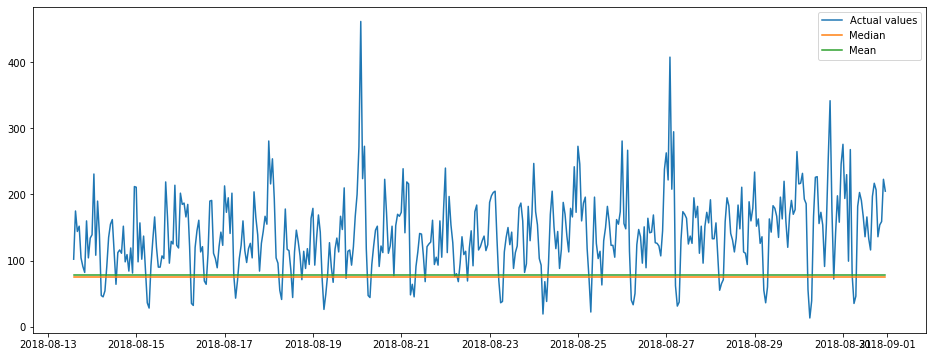

In [12]:
# Прогноз медианой и средним

predictions_median = test.shape[0] * [train.median()]
predictions_mean = test.shape[0] * [train.mean()]

print("Predict with median(rmse):", rmse(y_test, predictions_median))
print("Predict with mean(rmse):", rmse(y_test, predictions_mean))

plt.plot(X_test.index, y_test, label='Actual values')
plt.plot(X_test.index, predictions_median, label='Median')
plt.plot(X_test.index, predictions_mean, label='Mean')

plt.legend()
plt.show()

In [13]:
best_rmse = 10**5
values = [i for i in range(1, 100)]
for p in values:
    for q in values:
        ARMA_df = make_features(df_resample, p, q, differentiate=True) # include derivative though the time series is stationary
        
        train, test = train_test_split(ARMA_df, shuffle=False, test_size=0.1)
        train.dropna(inplace=True)
        
        X_train = train.drop("num_orders", axis=1)
        y_train = train["num_orders"]

        X_test = test.drop("num_orders", axis=1)
        y_test = test["num_orders"]
        
        lin_reg = lr()
        lin_reg.fit(X_train, y_train)

        preds = lin_reg.predict(X_train)
        
        current_rmse = rmse(preds, y_train)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_p = p
            best_q = q
print("RMSE:", best_rmse, "\nP:", best_p, "\nQ:", best_q)

RMSE: 3.414152858505434e-14 
P: 24 
Q: 70


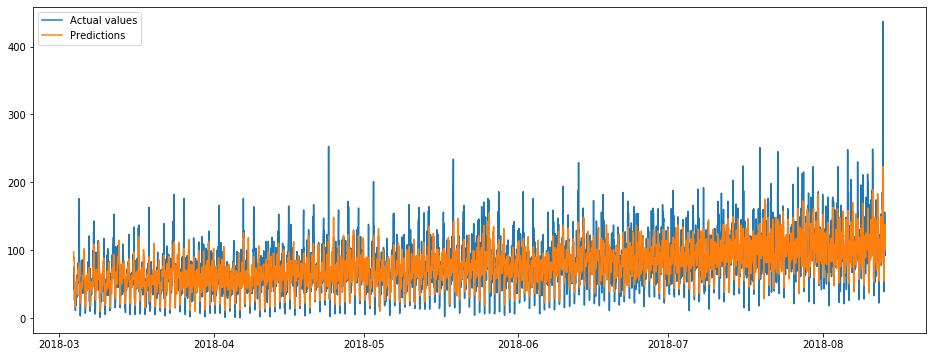

In [14]:
df_with_best_p_and_q = make_features(df_resample, best_p, best_q)

train, test = train_test_split(df_with_best_p_and_q, shuffle=False, test_size=0.1)
train.dropna(inplace=True)

X_train = train.drop("num_orders", axis=1)
y_train = train["num_orders"]

X_test = test.drop("num_orders", axis=1)
y_test = test["num_orders"]

best_lin_reg = lr().fit(X_train, y_train)
best_predictions_train = best_lin_reg.predict(X_train)

plt.plot(X_train.index, y_train, label='Actual values')
plt.plot(X_train.index, best_predictions_train, label='Predictions')
plt.legend()
plt.show()

# 4. Тестирование

RMSE: 44.94914190575092


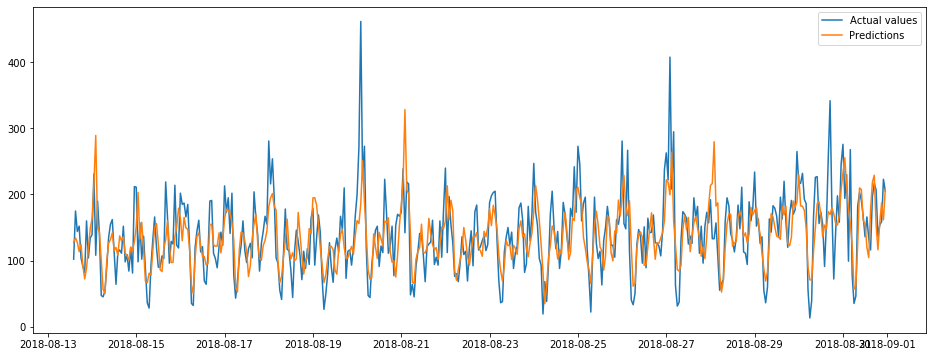

In [15]:
best_predictions = best_lin_reg.predict(X_test)

print("RMSE:", rmse(best_predictions, y_test))
plt.plot(X_test.index, y_test, label='Actual values')
plt.plot(X_test.index, best_predictions, label='Predictions')
plt.legend()
plt.show()